# Mesh Tutorial 1: Getting Started with PhysicsNeMo Mesh

Welcome to PhysicsNeMo-Mesh, NVIDIA's GPU-accelerated mesh processing library.

**The goal of this tutorial is to show you that PhysicsNeMo-Mesh is simple.** At its core,
a `Mesh` is just a dataclass with 5 fields:

| Field | Purpose | Shape |
|-------|---------|-------|
| `points` | Vertex coordinates | `(n_points, n_spatial_dims)` |
| `cells` | Connectivity (which points form each cell) | `(n_cells, n_manifold_dims + 1)` |
| `point_data` | Per-vertex data (optional) | `TensorDict` |
| `cell_data` | Per-cell data (optional) | `TensorDict` |
| `global_data` | Mesh-level data (optional) | `TensorDict` |

**Two fields define geometry. Three fields hold data. That's it!**

---

## What You'll Learn

1. Create a `Mesh` from scratch (points + cells)
2. Understand mesh dimensions (spatial, manifold, codimension)
3. Attach rich tensor data to points, cells, and the mesh itself
4. Visualize meshes with scalar field coloring
5. Move meshes between CPU and GPU with a single call

## Why PhysicsNeMo-Mesh?

Before diving in, here's why PhysicsNeMo-Mesh exists and what makes it special:

**GPU-Accelerated**: All operations are fully vectorized with PyTorch and run natively on CUDA.
No CPU bottlenecks - compute normals, curvature, gradients, and more on the GPU.

**Dimensionally Generic**: Works with n-dimensional manifolds embedded in m-dimensional spaces.
Point clouds (0D), curves (1D), surface meshes (2D), volume meshes (3D) - all with the same API.

**TensorDict Integration**: Data is stored in [TensorDict](https://github.com/pytorch/tensordict)
containers that move together with the mesh geometry. Call `.to("cuda")` and everything moves.

**Differentiable**: Most operations integrate seamlessly with PyTorch autograd, enabling
gradient-based optimization through mesh operations.

**Flexible Data**: Attach scalar, vector, or arbitrary-rank tensor fields to points, cells, or
globally. Nested data structures are fully supported.

In [1]:
import torch
from tensordict import TensorDict

from physicsnemo.mesh import Mesh

## Section 1: Creating a Mesh from Scratch

A `Mesh` needs just two tensors to define its geometry:

- **`points`**: Vertex coordinates - where each vertex is located in space
- **`cells`**: Connectivity - which vertices form each cell (triangle, tetrahedron, etc.)

Let's create the simplest possible mesh: two triangles forming a unit square in 2D.

In [2]:
# The geometry is defined by just 2 tensors!

# 1. Points: where are the vertices?
points = torch.tensor(
    [
        [0.0, 0.0],  # vertex 0: bottom-left
        [1.0, 0.0],  # vertex 1: bottom-right
        [1.0, 1.0],  # vertex 2: top-right
        [0.0, 1.0],  # vertex 3: top-left
    ]
)

# 2. Cells: which vertices form each triangle?
cells = torch.tensor(
    [
        [0, 1, 2],  # triangle 0: vertices 0, 1, 2
        [0, 2, 3],  # triangle 1: vertices 0, 2, 3
    ]
)

# Create the mesh
mesh = Mesh(points=points, cells=cells)
print(mesh)

Mesh(manifold_dim=2, spatial_dim=2, n_points=4, n_cells=2)
    point_data : {}
    cell_data  : {}
    global_data: {}


The output shows the 5 fields:
- Geometry: 4 points, 2 cells (triangles)
- Data: all three data containers are empty `{}`

Let's look at the key properties:

In [3]:
print(f"Number of points: {mesh.n_points}")
print(f"Number of cells: {mesh.n_cells}")
print()
print(f"Spatial dimension: {mesh.n_spatial_dims}")
print(f"Manifold dimension: {mesh.n_manifold_dims}")
print(f"Codimension: {mesh.codimension}")

Number of points: 4
Number of cells: 2

Spatial dimension: 2
Manifold dimension: 2
Codimension: 0


## Section 2: Understanding Mesh Dimensions

PhysicsNeMo-Mesh is **dimensionally generic**. It handles meshes of any dimension using
three key concepts:

| Concept | Meaning | Example |
|---------|---------|----------|
| **Spatial dimension** | Dimension of the embedding space | 3 for "real-world" 3D |
| **Manifold dimension** | Intrinsic dimension of each cell | 2 for triangles (they're flat) |
| **Codimension** | Spatial - Manifold | 1 for a surface in 3D |

The codimension tells you what geometric operations are possible:
- **Codimension 0**: Triangles in 2D, tetrahedra in 3D - no unique normal vector
- **Codimension 1**: Triangles in 3D, edges in 2D - unique normal vector exists
- **Codimension 2+**: Edges in 3D - infinitely many normal directions

Let's see some examples:

In [4]:
from physicsnemo.mesh.primitives.surfaces import sphere_icosahedral
from physicsnemo.mesh.primitives.planar import unit_square
from physicsnemo.mesh.primitives.volumes import cube_volume
from physicsnemo.mesh.primitives.curves import circle_3d

# Surface mesh: triangles in 3D space (codimension 1)
sphere = sphere_icosahedral.load(subdivisions=2)
print(
    f"Sphere: manifold={sphere.n_manifold_dims}D, spatial={sphere.n_spatial_dims}D, codim={sphere.codimension}"
)

# Planar mesh: triangles in 2D space (codimension 0)
square = unit_square.load(subdivisions=5)
print(
    f"Square: manifold={square.n_manifold_dims}D, spatial={square.n_spatial_dims}D, codim={square.codimension}"
)

# Volume mesh: tetrahedra in 3D space (codimension 0)
cube = cube_volume.load(subdivisions=3)
print(
    f"Cube:   manifold={cube.n_manifold_dims}D, spatial={cube.n_spatial_dims}D, codim={cube.codimension}"
)

# Curve mesh: edges in 3D space (codimension 2)
circle = circle_3d.load(n_points=32)
print(
    f"Circle: manifold={circle.n_manifold_dims}D, spatial={circle.n_spatial_dims}D, codim={circle.codimension}"
)

Sphere: manifold=2D, spatial=3D, codim=1
Square: manifold=2D, spatial=2D, codim=0
Cube:   manifold=3D, spatial=3D, codim=0
Circle: manifold=1D, spatial=3D, codim=2


## Section 3: Loading Meshes

Besides creating meshes manually, you can:

1. **Load from PyVista** - any format PyVista supports (VTK, STL, OBJ, PLY, etc.)
2. **Use built-in primitives** - spheres, cubes, tori, and more
3. **Load saved meshes** - `torch.load()` works directly on Mesh objects

In [5]:
# Load from PyVista
import pyvista as pv
from physicsnemo.mesh.io import from_pyvista

pv_mesh = pv.examples.load_airplane()
airplane = from_pyvista(pv_mesh)
print(f"Airplane: {airplane}")

Airplane: Mesh(manifold_dim=2, spatial_dim=3, n_points=1335, n_cells=2452)
    point_data : {}
    cell_data  : {}
    global_data: {}


In [6]:
# Load a pre-saved mesh (bunny asset included with tutorials)
bunny = torch.load("assets/bunny.pt", weights_only=False)
print(f"Bunny (coarse): {bunny}")

# Subdivide for higher resolution
bunny_fine = bunny.subdivide(levels=2, filter="loop")
print(f"Bunny (refined): {bunny_fine}")

Bunny (coarse): Mesh(manifold_dim=2, spatial_dim=3, n_points=400, n_cells=796)
    point_data : {}
    cell_data  : {}
    global_data: {}
Bunny (refined): Mesh(manifold_dim=2, spatial_dim=3, n_points=6370, n_cells=12736)
    point_data : {}
    cell_data  : {}
    global_data: {}


In [7]:
# Built-in primitives are organized by category
from physicsnemo.mesh.primitives.surfaces import torus
from physicsnemo.mesh.primitives.procedural import lumpy_sphere

donut = torus.load(major_radius=1.0, minor_radius=0.3, n_major=32, n_minor=16)
print(f"Torus: {donut}")

lumpy = lumpy_sphere.load(noise_amplitude=0.3, subdivisions=3, seed=42)
print(f"Lumpy sphere: {lumpy}")

Torus: Mesh(manifold_dim=2, spatial_dim=3, n_points=512, n_cells=1024)
    point_data : {}
    cell_data  : {}
    global_data: {}
Lumpy sphere: Mesh(manifold_dim=2, spatial_dim=3, n_points=642, n_cells=1280)
    point_data : {}
    cell_data  : {}
    global_data: {}


## Section 4: Attaching Data to Meshes

This is where PhysicsNeMo-Mesh really shines. You can attach **any tensor data** at three levels:

| Level | Stored In | Shape Prefix | Example |
|-------|-----------|--------------|----------|
| Per-vertex | `point_data` | `(n_points, ...)` | Temperature at each node |
| Per-cell | `cell_data` | `(n_cells, ...)` | Pressure in each element |
| Mesh-level | `global_data` | `(...)` | Reynolds number, timestep |

The trailing dimensions can be **anything**: scalars, vectors, matrices, or higher-rank tensors.

In [8]:
mesh = sphere_icosahedral.load(subdivisions=2)
print(f"Starting mesh: {mesh}")

Starting mesh: Mesh(manifold_dim=2, spatial_dim=3, n_points=162, n_cells=320)
    point_data : {}
    cell_data  : {}
    global_data: {}


In [9]:
# Scalar field: one value per point
mesh.point_data["temperature"] = torch.randn(mesh.n_points)

# Vector field: 3 values per point
mesh.point_data["velocity"] = torch.randn(mesh.n_points, 3)

# Rank-2 tensor field: 3x3 matrix per cell (e.g., stress tensor)
mesh.cell_data["stress"] = torch.randn(mesh.n_cells, 3, 3)

# Rank-3 tensor: 3x3x3 per cell (e.g., elasticity tensor components)
mesh.cell_data["elasticity"] = torch.randn(mesh.n_cells, 3, 3, 3)

print(f"With data attached: {mesh}")

With data attached: Mesh(manifold_dim=2, spatial_dim=3, n_points=162, n_cells=320)
    point_data : {temperature: (), velocity: (3,)}
    cell_data  : {elasticity: (3, 3, 3), stress: (3, 3)}
    global_data: {}


Notice how the `__repr__` shows the trailing dimensions for each field:
- `temperature: ()` means scalar (no trailing dims)
- `velocity: (3,)` means 3-vector
- `stress: (3, 3)` means 3x3 matrix
- `elasticity: (3, 3, 3)` means 3x3x3 tensor

In [10]:
# Global data: mesh-level quantities
mesh.global_data["time"] = torch.tensor(0.0)
mesh.global_data["reynolds_number"] = torch.tensor(1e6)

# Nested TensorDict for structured metadata
mesh.global_data["simulation_params"] = TensorDict(
    {
        "dt": torch.tensor(0.001),
        "inlet_velocity": torch.tensor([1.0, 0.0, 0.0]),
        "boundary_conditions": TensorDict(
            {
                "inlet": torch.tensor(1),
                "outlet": torch.tensor(2),
                "wall": torch.tensor(3),
            },
            batch_size=[],
        ),
    },
    batch_size=[],
)

print(f"With global data: {mesh}")

With global data: Mesh(manifold_dim=2, spatial_dim=3, n_points=162, n_cells=320)
    point_data : {temperature: (), velocity: (3,)}
    cell_data  : {elasticity: (3, 3, 3), stress: (3, 3)}
    global_data: {
        reynolds_number  : (),
        simulation_params: {
            boundary_conditions: {inlet: (), outlet: (), wall: ()},
            dt                 : (),
            inlet_velocity     : (3,)},
        time             : ()}


In [11]:
# Access data like a dictionary
print(f"Temperature shape: {mesh.point_data['temperature'].shape}")
print(f"Stress shape: {mesh.cell_data['stress'].shape}")
print(f"Reynolds number: {mesh.global_data['reynolds_number'].item():.0e}")

# Access nested data
print(f"Inlet velocity: {mesh.global_data['simulation_params', 'inlet_velocity']}")

Temperature shape: torch.Size([162])
Stress shape: torch.Size([320, 3, 3])
Reynolds number: 1e+06
Inlet velocity: tensor([1., 0., 0.])


**A note on data and transformations:** Data fields (`point_data`, `cell_data`, `global_data`)
are **decoupled from geometry** by default. If you rotate or scale a mesh (covered in Tutorial 2),
only the vertex coordinates in `points` are transformed - attached data like `inlet_velocity` is
left unchanged. This is the right default for scalar fields (e.g., temperature is invariant under
rotation) but may surprise you for vector fields.

When you *do* want vector/tensor data to co-rotate with the geometry, the transformation methods
accept opt-in flags: `transform_point_data=True`, `transform_cell_data=True`, and
`transform_global_data=True`. See Tutorial 2 for details.

## Section 5: Visualization

The `.draw()` method provides one-line visualization with automatic backend selection:
- **2D meshes**: Uses matplotlib (static plots)
- **3D meshes**: Uses PyVista (interactive 3D viewer)

These can be overridden by passing `backend="matplotlib"` or `backend="pyvista"` to the method. Normally, the PyVista backend provides a better experience in 3D, but in order to render these visualizations statically in this Jupyter notebook, we'll use matplotlib.

**Interactive 3D with PyVista:** When running locally with `backend="pyvista"` (the default
for 3D meshes), you get a fully interactive 3D viewer where you can rotate, zoom, and pan
the mesh. PyVista also supports Jupyter widgets via `pv.set_jupyter_backend("trame")` for
in-notebook interactivity. The `.draw()` method returns a `pyvista.Plotter` object that you
can further customize before displaying.

You can color meshes by any scalar field. Vector fields are automatically converted to
their L2 norm (magnitude) for coloring.

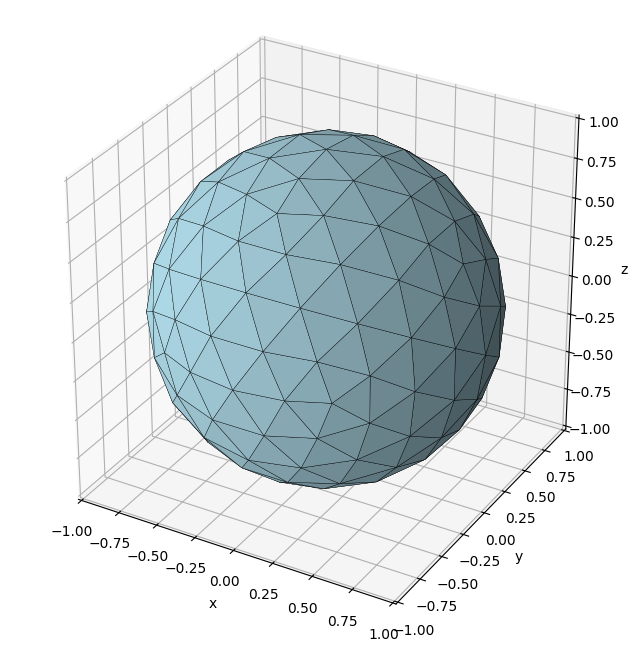

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [12]:
# Basic visualization
mesh.draw("matplotlib")

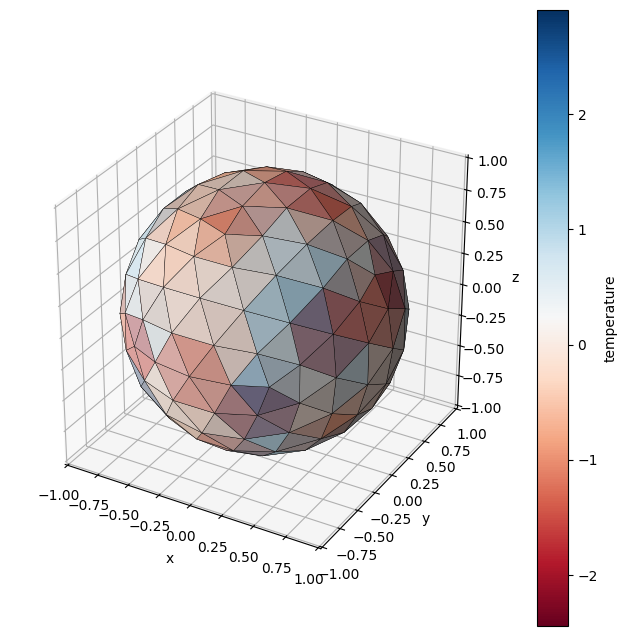

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [13]:
# Color by point scalar field - point data automatically gets converted to cell data for visualization
mesh.draw(point_scalars="temperature", cmap="RdBu", backend="matplotlib")

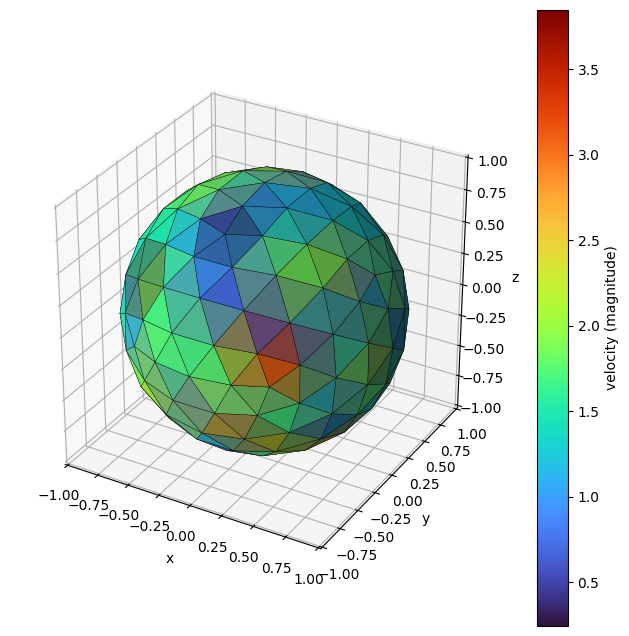

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [14]:
# Color by velocity magnitude (vector -> L2 norm automatically)
mesh.draw(point_scalars="velocity", cmap="turbo", backend="matplotlib")

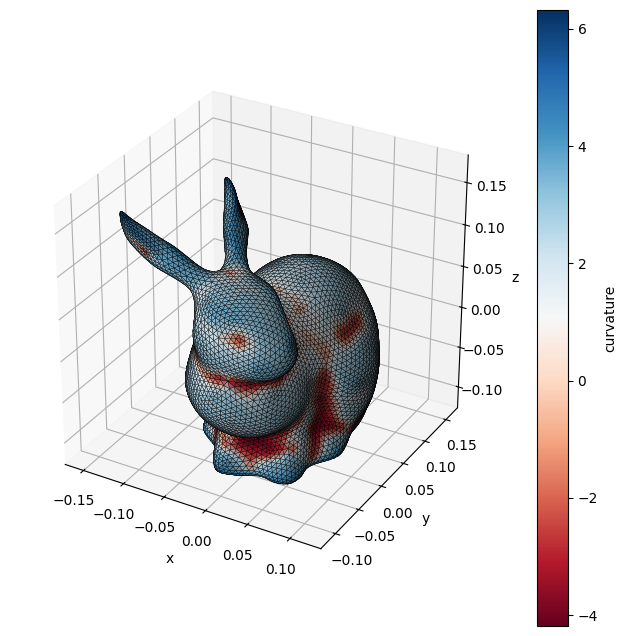

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [15]:
# Visualize the bunny with curvature information
bunny = torch.load("assets/bunny.pt", weights_only=False).subdivide(2, "loop")
curvature = bunny.mean_curvature_vertices


def regularize(x):
    return x.sign() * x.abs().log1p()


bunny.point_data["curvature"] = regularize(curvature)
bunny.draw(point_scalars="curvature", cmap="RdBu", backend="matplotlib")

## Section 6: GPU Acceleration

One of PhysicsNeMo-Mesh's key features is seamless GPU acceleration. The entire mesh -
geometry AND all attached data - moves together with a single `.to()` call.

This is possible because mesh data uses TensorDict, which handles device transfers automatically.

In [16]:
# Create a mesh with data
mesh = sphere_icosahedral.load(subdivisions=3)
mesh.point_data["temperature"] = torch.randn(mesh.n_points)
mesh.cell_data["pressure"] = torch.randn(mesh.n_cells)

print(f"Initial device: {mesh.device}")
print(f"  points: {mesh.points.device}")
print(f"  temperature: {mesh.point_data['temperature'].device}")

Initial device: None
  points: cpu
  temperature: cpu


In [17]:
if torch.cuda.is_available():
    # Move EVERYTHING to GPU with one call
    mesh_gpu = mesh.to("cuda")

    print(f"After .to('cuda'):")
    print(f"  device: {mesh_gpu.device}")
    print(f"  points: {mesh_gpu.points.device}")
    print(f"  temperature: {mesh_gpu.point_data['temperature'].device}")
    print(f"  pressure: {mesh_gpu.cell_data['pressure'].device}")

    # All computations are now GPU-accelerated!
    curvature = mesh_gpu.gaussian_curvature_vertices
    print(f"\nComputed Gaussian curvature on GPU: {curvature.device}")

    # Move back to CPU when needed (e.g., for visualization)
    mesh_cpu = mesh_gpu.to("cpu")
    print(f"Back on CPU: {mesh_cpu.device}")
else:
    print("CUDA not available - GPU demo skipped.")
    print("When CUDA is available, use mesh.to('cuda') to move to GPU.")

After .to('cuda'):
  device: cuda:0
  points: cuda:0
  temperature: cuda:0
  pressure: cuda:0

Computed Gaussian curvature on GPU: cuda:0
Back on CPU: cpu


## Section 7: Differentiability (Autograd Integration)

Almost all PhysicsNeMo-Mesh operations are differentiable and integrate with PyTorch's autograd.
This enables gradient-based optimization through mesh operations - useful for inverse problems,
physics-informed neural networks, and shape optimization.

In [18]:
# Create points with gradient tracking
points = torch.tensor(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.5, 1.0],
    ],
    requires_grad=True,
)

cells = torch.tensor([[0, 1, 2]])
mesh = Mesh(points=points, cells=cells)

# Compute area (differentiable!)
area = mesh.cell_areas.sum()
print(f"Triangle area: {area.item():.4f}")

# Backpropagate through the area computation
area.backward()
print(f"Gradient of area w.r.t. vertices:\n{points.grad}")

Triangle area: 0.5000
Gradient of area w.r.t. vertices:
tensor([[-0.5000, -0.2500],
        [ 0.5000, -0.2500],
        [ 0.0000,  0.5000]])


The gradients show how moving each vertex affects the triangle's area. This is the foundation
for mesh-based optimization and physics-informed learning.

You can also enable gradient tracking on an **existing** mesh by detaching its points into
a leaf tensor. This is useful when you want to optimize the shape of a mesh that was loaded
from a file or generated by a primitive:

In [19]:
# Start from an existing mesh (not created with requires_grad)
mesh = sphere_icosahedral.load(subdivisions=2)

# Detach points and make them leaf tensors for gradient tracking
mesh.points = mesh.points.detach().requires_grad_(True)

# Now compute something differentiable
total_area = mesh.cell_areas.sum()
total_area.backward()

print(f"Gradient shape: {mesh.points.grad.shape}")
print(f"Gradient norm: {mesh.points.grad.norm():.4f}")

Gradient shape: torch.Size([162, 3])
Gradient norm: 1.9463


## Summary

You've learned the fundamentals of PhysicsNeMo-Mesh:

1. **A Mesh is simple**: Just 5 fields - 2 for geometry (`points`, `cells`), 3 for data
2. **Dimensionally generic**: Works with any n-manifold in m-space
3. **Rich data support**: Scalar, vector, tensor, and nested data on points/cells/globally
4. **Easy visualization**: `.draw()` with automatic backend selection
5. **GPU-accelerated**: `.to("cuda")` moves everything together
6. **Differentiable**: Integrates with PyTorch autograd

For the complete feature list, see the [physicsnemo.mesh README](../../../physicsnemo/mesh/README.md).